# Conservation Analysis of Genomic Features

This notebook analyzes conservation patterns in alternative transcript regions using PhyloCSF and PhyloP scores. The analysis pipeline is designed to handle multiple types of genomic features:
- N-terminal extensions (ctes)
- C-terminal extensions (CTEs)
- Intronic regions

## Setup
First, we'll import required libraries and set up our basic configuration. We use:
- `polars` for efficient data manipulation
- `pyranges` for genomic icterval operations
- `pyBigWig` for accessing conservation scores
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for visualization

In [13]:
# Standard libraries
from pathlib import Path
import sys
from datetime import datetime

# Add project root to Python path for imports
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.append(project_root)

# Custom utilities
from src.utils import ConservationTracker, ConservationAnalyzer, BEDHandler

# Data handling
import polars as pl
import numpy as np
import pyranges as pr
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme()
sns.set_context("notebook")

## Configuration

Set up paths and parameters for the analysis. This notebook is configured for N-terminal extensions (ctes), but the same structure can be used for CTEs and intronic regions by modifying these parameters.

Key parameters:
- Feature type (NTE/CTE/intronic)
- Input paths for feature data, annotations, and conservation scores
- Analysis parameters like window size
- Output directory structure

In [14]:
# Define feature type
FEATURE_TYPE = "TRANSLATED_INTRONS"  # One of: "NTE", "CTE", "INTRONIC"

# Set up directory structure
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results" / FEATURE_TYPE.lower()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
for subdir in ["figures", "tables", "bed"]:
   (RESULTS_DIR / subdir).mkdir(parents=True, exist_ok=True)


# Input paths
feature_path = DATA_DIR / "raw" / "intron_candidates_new.bed12"
gencode_path = DATA_DIR / "raw" / "gencode.v47.annotation.gtf"
phylocsf_dir = DATA_DIR / "raw" / "phylocsf"
phylop_path = DATA_DIR / "raw" / "phyloP" / "PhyloP_470way.bw"

# Analysis parameters
WINDOW_SIZE = 30  # Size of sliding window for conservation analysis
MIN_REGION_SIZE = 10  # Minimum size of region to analyze
SCORE_THRESHOLD = 0  # Threshold for calling positive conservation

# Initialize our utility classes
conservation_tracker = ConservationTracker(phylocsf_dir, phylop_path)
conservation_analyzer = ConservationAnalyzer(window_size=WINDOW_SIZE)
bed_handler = BEDHandler()

# Verify paths exist
for path in [feature_path, gencode_path, phylocsf_dir, phylop_path]:
    if not path.exists():
        raise FileNotFoundError(f"Required file/directory not found: {path}")

print("Configuration complete. Analysis will use:")
print(f"- Feature type: {FEATURE_TYPE}")
print(f"- Feature data: {feature_path}")
print(f"- Results directory: {RESULTS_DIR}")

Configuration complete. Analysis will use:
- Feature type: TRANSLATED_INTRONS
- Feature data: ../data/raw/intron_candidates_new.bed12
- Results directory: ../results/translated_introns


## Data Loading and Preprocessing

Load our N-terminal extension data from the BED12 file and prepare it for analysis. Steps include:
1. Load the BED12 file using our custom handler
2. Extract transcript IDs from feature names
3. Basic QC checks on the loaded data
4. Display summary statistics of our features

Loading feature data...

Feature Statistics:
Total features loaded: 2295

Chromosome distribution:
shape: (24, 2)
┌───────┬───────┐
│ chrom ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ 1     ┆ 219   │
│ 10    ┆ 89    │
│ 11    ┆ 118   │
│ 12    ┆ 140   │
│ 13    ┆ 38    │
│ …     ┆ …     │
│ 7     ┆ 131   │
│ 8     ┆ 64    │
│ 9     ┆ 106   │
│ X     ┆ 49    │
│ Y     ┆ 2     │
└───────┴───────┘

Strand distribution:
shape: (2, 2)
┌────────┬───────┐
│ strand ┆ count │
│ ---    ┆ ---   │
│ str    ┆ u32   │
╞════════╪═══════╡
│ -      ┆ 1092  │
│ +      ┆ 1203  │
└────────┴───────┘

Length statistics:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ region_length │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 2295.0        │
│ null_count ┆ 0.0           │
│ mean       ┆ 105.267974    │
│ std        ┆ 73.023692     │
│ min        ┆ 12.0          │
│ 25%        ┆ 48.0          │
│ 50%        ┆ 87

/tmp/ipykernel_25045/2832992967.py:18: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
/tmp/ipykernel_25045/2832992967.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  print(feature_df.group_by("strand").agg(pl.count()))


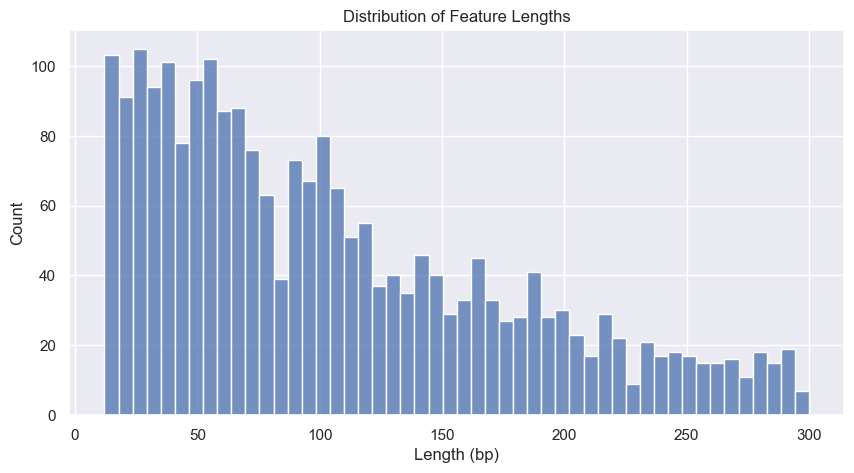


Data loading and preprocessing complete.


In [15]:
# Load feature data using our BED handler
print("Loading feature data...")
feature_df = bed_handler.load_bed12(feature_path)

# Extract transcript IDs from names and add region length
feature_df = feature_df.with_columns([
    # Extract transcript ID from feature name (assumes format: ENST00000123456_...)
    pl.col("name").str.split("_").list.first().alias("transcript_id"),
    
    # Calculate region length
    (pl.col("chromEnd") - pl.col("chromStart")).alias("region_length")
])

# Print basic statistics
print("\nFeature Statistics:")
print(f"Total features loaded: {len(feature_df)}")
print("\nChromosome distribution:")
print(feature_df.group_by("chrom").agg(pl.count()).sort("chrom"))
print("\nStrand distribution:")
print(feature_df.group_by("strand").agg(pl.count()))
print("\nLength statistics:")
print(feature_df.select("region_length").describe())

# Quick length distribution plot
plt.figure(figsize=(10, 5))
sns.histplot(data=feature_df.to_pandas(), x="region_length", bins=50)
plt.title("Distribution of Feature Lengths")
plt.xlabel("Length (bp)")
plt.ylabel("Count")
plt.show()

print("\nData loading and preprocessing complete.")

## Extension Region Identification

Before calculating conservation scores, we need to precisely identify the extension regions by:
1. Loading CDS annotations from GENCODE
2. Identifying the correct CDS start/end positions
3. Determining the extension coordinates based on strand orientation:
   - For + strand: region between chromStart and CDS start
   - For - strand: region between CDS end and chromEnd
4. Validating extension regions

In [16]:
# Load GENCODE annotation
print("Loading GENCODE v47 annotation...")
gr = pr.read_gtf(gencode_path)

# Get both CDS and exon annotations
cds_annotation = gr[gr.Feature == "CDS"]
exon_annotation = gr[gr.Feature == "exon"]

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")
print(f"Found {len(exon_annotation)} exon entries in GENCODE v47")

# Convert both to polars
cds_df = pl.DataFrame({
    "transcript_id": [i.split('.')[0] for i in cds_annotation.transcript_id.to_list()],
    "chrom": [str(x).replace('chr', '') for x in cds_annotation.Chromosome.to_list()],
    "strand": cds_annotation.Strand.to_list(),
    "cds_start": cds_annotation.Start.to_list(),
    "cds_end": cds_annotation.End.to_list(),
    "cds_frame": cds_annotation.Frame.to_list(),
    "gene_name": cds_annotation.gene_name.to_list()
})

Loading GENCODE v47 annotation...
Found 901768 CDS entries in GENCODE v47
Found 2155005 exon entries in GENCODE v47


In [17]:
def identify_cds_introns(cds_blocks_df):
    """
    Identify introns between CDS blocks while properly handling strand orientation.

    Args:
        cds_blocks_df: DataFrame containing CDS blocks from PyRanges GTF
                      Contains columns: Start, End, Strand, transcript_id

    Returns:
        DataFrame containing intron coordinates
    """
    introns = []

    # Group CDS blocks by transcript_id
    for transcript_id, group in cds_blocks_df.groupby('transcript_id'):
        # Sort CDS blocks based on genomic coordinates
        # For - strand, we'll reverse the order later if needed
        blocks = group.sort_values('Start').to_dict('records')

        if len(blocks) <= 1:
            continue

        # Get strand information
        strand = blocks[0]['Strand']

        # For minus strand, reverse the order of blocks
        if strand == '-':
            blocks = blocks[::-1]

        # Iterate through adjacent CDS blocks
        for i in range(len(blocks) - 1):
            current_cds = blocks[i]
            next_cds = blocks[i + 1]

            # Define intron boundaries based on strand
            if strand == '+':
                intron_start = current_cds['End']
                intron_end = next_cds['Start']
            else:
                intron_start = next_cds['End']
                intron_end = current_cds['Start']

            # Validate intron coordinates
            if intron_start >= intron_end:
                continue

            introns.append({
                'transcript_id': transcript_id,
                'strand': strand,
                'intron_start': intron_start,
                'intron_end': intron_end,
                'chromosome': current_cds['Chromosome'],  # PyRanges uses 'Chromosome'
            })

    return pd.DataFrame(introns)

# Get CDS annotations and ensure transcript_id is available
cds_annotation = gr[gr.Feature == "CDS"]
cds_df = cds_annotation.as_df()

# Extract transcript_id from attributes if needed
if 'transcript_id' not in cds_df.columns:
    print("Extracting transcript_id from attributes...")
    # GTF format stores transcript_id in attributes column
    cds_df['transcript_id'] = cds_df['gene_name'].str.extract('transcript_id "([^"]+)"')

print(f"Found {len(cds_annotation)} CDS entries in GENCODE v47")
print("Identifying introns between CDS blocks...")
cds_introns = identify_cds_introns(cds_df)

Found 901768 CDS entries in GENCODE v47
Identifying introns between CDS blocks...


In [18]:
def calculate_all_scores(feature_df, cds_introns_pl, conservation_tracker, conservation_analyzer):
    """
    Calculate conservation metrics for both translated regions and full CDS introns
    """
    from time import time
    import numpy as np
    
    # Initialize lists for all our metrics
    metrics_lists = {
        # Translated region metrics
        'translated_frame_score': [],    # Score in translated region
        'translated_max_score': [],      # Best frame in translated region
        'translated_phylop': [],         # PhyloP in translated region
        'translated_window_max': [],     # Best 30bp window in translated region
        
        # Untranslated intron metrics
        'untranslated_frame_score': [],  # Score in untranslated regions
        'untranslated_max_score': [],    # Best frame in untranslated regions
        'untranslated_phylop': [],       # PhyloP in untranslated regions
        'untranslated_window_max': [],   # Best 30bp window in untranslated regions
        
        # Region lengths
        'translated_length': [],         # Length of translated region
        'untranslated_length': [],      # Length of untranslated regions
        'intron_start': [],             # Full intron start
        'intron_end': [],               # Full intron end
        'frame': []                      # Frame of translation
    }
    
    total_features = len(feature_df)
    processed = 0
    matches_found = 0
    
    for row in feature_df.iter_rows(named=True):
        if processed % 100 == 0:
            print(f"Processed {processed}/{total_features} features "
                  f"({processed/total_features*100:.1f}%)")
        
        processed += 1
        
        # Initialize default values
        current_metrics = {key: None for key in metrics_lists.keys()}
        
        # Find matching introns
        matching_introns = cds_introns_pl.filter(
            (pl.col("chromosome") == f"chr{row['chrom']}") &
            (pl.col("intron_start") <= row['thickStart']) &
            (pl.col("intron_end") >= row['thickEnd']) &
            (pl.col("strand") == row['strand'])
        )
        
        if processed <= 2:  # Debug first 5 entries
            print(f"\nProcessing entry {processed}:")
            print(f"Looking for introns in transcript matching:")
            print(f"Chrom: chr{row['chrom']}")
            print(f"Region: {row['thickStart']}-{row['thickEnd']}")
            print(f"Strand: {row['strand']}")
            print(f"Found {len(matching_introns)} matching introns:")
            print(matching_introns)
        
        if len(matching_introns) == 0:
            # Add None values for this row
            for key in metrics_lists:
                metrics_lists[key].append(None)
            continue
        
        matches_found += 1
        # Convert first matching intron to dict for easier access
        intron_dict = matching_introns.row(0, named=True)
        
        current_metrics['intron_start'] = intron_dict['intron_start']
        current_metrics['intron_end'] = intron_dict['intron_end']
        
        # Calculate frame
        frame = (row['thickEnd']) % 3 + 1
        print(row['thickStart'] - intron_dict['intron_start'], row['thickStart'], intron_dict['intron_start'])
        current_metrics['frame'] = frame
        
        # 1. Analyze translated region
        translated_scores, translated_phylop = conservation_tracker.get_conservation_scores(
            row['chrom'],
            row['thickStart'],
            row['thickEnd'],
            row['strand']
        )
        
        current_metrics['translated_length'] = row['thickEnd'] - row['thickStart']
        
        if translated_scores:
            frame_means = {
                f: np.nanmean(scores) if len(scores) > 0 else np.nan 
                for f, scores in translated_scores.items()
            }
            
            current_metrics['translated_frame_score'] = frame_means.get(frame)
            current_metrics['translated_max_score'] = max(frame_means.values())
            
            scores = translated_scores[frame]
            if len(scores) >= 30:
                windows = [
                    np.nanmean(scores[i:i+30])
                    for i in range(len(scores) - 30 + 1)
                ]
                current_metrics['translated_window_max'] = float(max(windows))
        
        if translated_phylop is not None:
            current_metrics['translated_phylop'] = float(np.nanmean(translated_phylop))
        
        # 2. Analyze untranslated regions
        untranslated_regions = []
        if row['thickStart'] > intron_dict['intron_start']:
            untranslated_regions.append((
                intron_dict['intron_start'],
                row['thickStart']
            ))
        if row['thickEnd'] < intron_dict['intron_end']:
            untranslated_regions.append((
                row['thickEnd'],
                intron_dict['intron_end']
            ))
        
        # Combine scores from all untranslated regions
        all_untranslated_scores = {1: [], 2: [], 3: []}
        all_untranslated_phylop = []
        total_untranslated_length = 0
        
        for start, end in untranslated_regions:
            scores, phylop = conservation_tracker.get_conservation_scores(
                row['chrom'],
                start,
                end,
                row['strand']
            )
            
            total_untranslated_length += end - start
            
            if scores:
                for frame_num in [1, 2, 3]:
                    all_untranslated_scores[frame_num].extend(scores.get(frame_num, []))
            
            if phylop is not None:
                all_untranslated_phylop.extend(phylop)
        
        current_metrics['untranslated_length'] = total_untranslated_length
        
        if any(all_untranslated_scores.values()):
            frame_means = {
                f: np.nanmean(scores) if len(scores) > 0 else np.nan 
                for f, scores in all_untranslated_scores.items()
            }
            
            current_metrics['untranslated_frame_score'] = frame_means.get(frame)
            current_metrics['untranslated_max_score'] = max(frame_means.values())
            
            scores = all_untranslated_scores[frame]
            if len(scores) >= 30:
                windows = [
                    np.nanmean(scores[i:i+30])
                    for i in range(len(scores) - 30 + 1)
                ]
                current_metrics['untranslated_window_max'] = float(max(windows))
        
        if all_untranslated_phylop:
            current_metrics['untranslated_phylop'] = float(np.nanmean(all_untranslated_phylop))
        
        # Add all metrics to their respective lists
        for key in metrics_lists:
            metrics_lists[key].append(current_metrics[key])
    
    print(f"\nProcessing Summary:")
    print(f"Total entries processed: {total_features}")
    print(f"Matching introns found: {matches_found}")
    print(f"Percentage with matches: {(matches_found/total_features)*100:.1f}%")
    
    # Add all metrics to DataFrame
    return feature_df.with_columns([
        pl.Series(name, values) for name, values in metrics_lists.items()
    ])

cds_introns_pl = pl.from_pandas(cds_introns)


print("Calculating conservation scores...")
scored_df = calculate_all_scores(feature_df, cds_introns_pl, conservation_tracker, conservation_analyzer)

# Add coordinate strings for reference
scored_df = scored_df.with_columns([
    # Translated region coordinates
    (pl.col("chrom") + ":" + 
     pl.col("thickStart").cast(pl.Utf8) + "-" +
     pl.col("thickEnd").cast(pl.Utf8)
    ).alias("translated_coords"),
    
    # Full intron coordinates
    (pl.col("chrom") + ":" + 
     pl.col("intron_start").cast(pl.Utf8) + "-" +
     pl.col("intron_end").cast(pl.Utf8)
    ).alias("intron_coords")
])

print("\nSample of scored regions:")
print(scored_df.select([
    "transcript_id",
    "translated_coords",
    "intron_coords",
    "strand",
    "translated_frame_score",
    "untranslated_frame_score",
    "translated_phylop",
    "untranslated_phylop",
    "translated_length",
    "untranslated_length",
    "frame"
]).head())

Calculating conservation scores...
Processed 0/2295 features (0.0%)

Processing entry 1:
Looking for introns in transcript matching:
Chrom: chr1
Region: 1013576-1013732
Strand: +
Found 1 matching introns:
shape: (1, 5)
┌───────────────────┬────────┬──────────────┬────────────┬────────────┐
│ transcript_id     ┆ strand ┆ intron_start ┆ intron_end ┆ chromosome │
│ ---               ┆ ---    ┆ ---          ┆ ---        ┆ ---        │
│ str               ┆ str    ┆ i64          ┆ i64        ┆ str        │
╞═══════════════════╪════════╪══════════════╪════════════╪════════════╡
│ ENST00000649529.1 ┆ +      ┆ 1013576      ┆ 1013983    ┆ chr1       │
└───────────────────┴────────┴──────────────┴────────────┴────────────┘
0 1013576 1013576

Processing entry 2:
Looking for introns in transcript matching:
Chrom: chr1
Region: 22563731-22563824
Strand: +
Found 2 matching introns:
shape: (2, 5)
┌───────────────────┬────────┬──────────────┬────────────┬────────────┐
│ transcript_id     ┆ strand ┆ int

/tmp/ipykernel_25045/2255345499.py:158: RuntimeWarning: Mean of empty slice
  np.nanmean(scores[i:i+30])


0 28553137 28553137
0 28737147 28737147
2 32014379 32014377
2 32073053 32073051
0 32222444 32222444
2 32292220 32292218
0 35558223 35558223
2 36089117 36089115
0 42658512 42658512
2 45340306 45340304
0 46303820 46303820
0 50970497 50970497
2 54200591 54200589
0 70411583 70411583
0 75724817 75724817
0 75786274 75786274
0 85581047 85581047
0 92832117 92832117
0 100133315 100133315
0 103526262 103526262
0 108692867 108692867
0 110034817 110034817
0 151008671 151008671
0 151166203 151166203
0 153990802 153990802
1 154974805 154974804
0 154984066 154984066
0 156729215 156729215
0 161258983 161258983
0 203861713 203861713
0 212859190 212859190
2 219173983 219173981
0 224114396 224114396
0 224356993 224356993
0 225778012 225778012
2 229271372 229271370
2 240093726 240093724
2 243256242 243256240
0 244653355 244653355
1063 1324350 1323287
505 6235479 6234974
8073 19209888 19201815
4591 23825184 23820593
148 25232359 25232211
3136 31296484 31293348
6091 32817148 32811057
9152 36149318 36140166


/tmp/ipykernel_25045/2255345499.py:101: RuntimeWarning: Mean of empty slice
  np.nanmean(scores[i:i+30])


2015 60648592 60646577
2275 68792767 68790492
2290 75126513 75124223
2950 76812593 76809643
3179 77707656 77704477
6126 92039379 92033253
144 94129435 94129291
48 106374012 106373964
74 106538190 106538116
2 31327791 31327789
0 40405971 40405971
0 40807868 40807868
0 40953814 40953814
2 43792385 43792383
0 43827092 43827092
14360 49170376 49156016
0 63042943 63042943
2 66704077 66704075
0 68054350 68054350
0 69453020 69453020
0 75336092 75336092
0 76931985 76931985
2 78873059 78873057
0 89576240 89576240
1 90265877 90265876
2 96332549 96332547
2001 23039153 23037152
1104 42273227 42272123
30687 52788534 52757847
99886 59372335 59272449
809 63157330 63156521
502 64162656 64162154
2174 65029214 65027040
15021 65286093 65271072
1207 66504736 66503529
32565 68820484 68787919
63381 70763041 70699660
8824 70891732 70882908
Processed 300/2295 features (13.1%)
14483 77070738 77056255
7264 80989446 80982182
24191 84715835 84691644
89 89750316 89750227
0 54058 54058
2 668238 668236
0 721436 7214

/tmp/ipykernel_25045/2255345499.py:91: RuntimeWarning: Mean of empty slice
  f: np.nanmean(scores) if len(scores) > 0 else np.nan


0 19901091 19901091
0 20776450 20776450
0 20923403 20923403
0 21505774 21505774
0 22286555 22286555
0 23117176 23117176
0 32581327 32581327
0 32692674 32692674
0 34428570 34428570
0 39391638 39391638
0 39480961 39480961
1 47745784 47745783
2 48954964 48954962
0 48965609 48965609
0 48993923 48993923
0 49044224 49044224
0 49335609 49335609
0 49487644 49487644
0 52269631 52269631
0 57435593 57435593
0 57584389 57584389
0 57850071 57850071
8483 344656 336173
17625 2015088 1997463
20 2427344 2427324
5837 3557031 3551194
919 3985269 3984350
33275 4400269 4366994
5375 5719646 5714271
516 8513857 8513341
2759 12734180 12731421
231 12775128 12774897
3274 19138161 19134887
14918 20039294 20024376
11763 20565598 20553835
14864 20661269 20646405


/tmp/ipykernel_25045/2255345499.py:148: RuntimeWarning: Mean of empty slice
  f: np.nanmean(scores) if len(scores) > 0 else np.nan


18453 21329080 21310627
20344 23395108 23374764
4645 29212803 29208158
5225 32971691 32966466
61 39435769 39435708
2120 45781989 45779869
7107 46745995 46738888
1041 48618918 48617877
274 49048646 49048372
11796 51366104 51354308
120 54339021 54338901
11583 57888625 57877042
4081 57916270 57912189
2 265009 265007
0 8682513 8682513
0 9207230 9207230
0 27212467 27212467
2 27442442 27442440
0 27583142 27583142
0 28894923 28894923
0 32165903 32165903
0 42048838 42048838
0 65227957 65227957
Processed 500/2295 features (21.8%)
2 70900870 70900868
2 72887738 72887736
0 73234384 73234384
0 74554814 74554814
0 74958892 74958892
2 86720811 86720809
2 90038995 90038993
0 105038227 105038227
0 108719678 108719678
0 112055756 112055756
2 112482503 112482501
0 112542671 112542671
0 130342935 130342935
1 134919013 134919012
2 152719026 152719024
0 170929403 170929403
0 197516146 197516146
0 203239134 203239134
0 216498877 216498877
0 229922609 229922609
0 231708751 231708751
0 237086042 237086042
106

## Conservation Score Calculation

Calculate both PhyloCSF and PhyloP conservation scores for extension regions using our utility classes. For each region we:
1. Use `ConservationTracker` to access scores
2. Calculate metrics using `ConservationAnalyzer`
3. Store results in a properly structured DataFrame

In [19]:
feature_df.columns


['chrom',
 'chromStart',
 'chromEnd',
 'name',
 'score',
 'strand',
 'thickStart',
 'thickEnd',
 'itemRgb',
 'blockCount',
 'blockSizes',
 'blockStarts',
 'transcript_id',
 'region_length']

## High-Confidence Extension Analysis

Filter and categorize the extensions based on conservation scores:
1. Filter for positive PhyloCSF scores (indicating coding potential)
2. Sort by conservation strength
3. Separate novel vs. overlapping extensions
4. Generate visualizations and summary statistics


Score statistics for intron regions:
shape: (10, 9)
┌────────────┬────────────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬───────┐
│ transcript ┆ translated ┆ intron_coo ┆ strand ┆ … ┆ untranslat ┆ translated ┆ untranslat ┆ frame │
│ _id        ┆ _coords    ┆ rds        ┆ ---    ┆   ┆ ed_frame_s ┆ _phylop    ┆ ed_phylop  ┆ ---   │
│ ---        ┆ ---        ┆ ---        ┆ str    ┆   ┆ core       ┆ ---        ┆ ---        ┆ i64   │
│ str        ┆ str        ┆ str        ┆        ┆   ┆ ---        ┆ f64        ┆ f64        ┆       │
│            ┆            ┆            ┆        ┆   ┆ f64        ┆            ┆            ┆       │
╞════════════╪════════════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪═══════╡
│ ENST000006 ┆ 1:1013576- ┆ 1:1013576- ┆ +      ┆ … ┆ -28.361789 ┆ -0.363019  ┆ -0.328809  ┆ 3     │
│ 49529      ┆ 1013732    ┆ 1013983    ┆        ┆   ┆            ┆            ┆            ┆       │
│ ENST000001 ┆ 1:22563731 ┆ 1:22563729

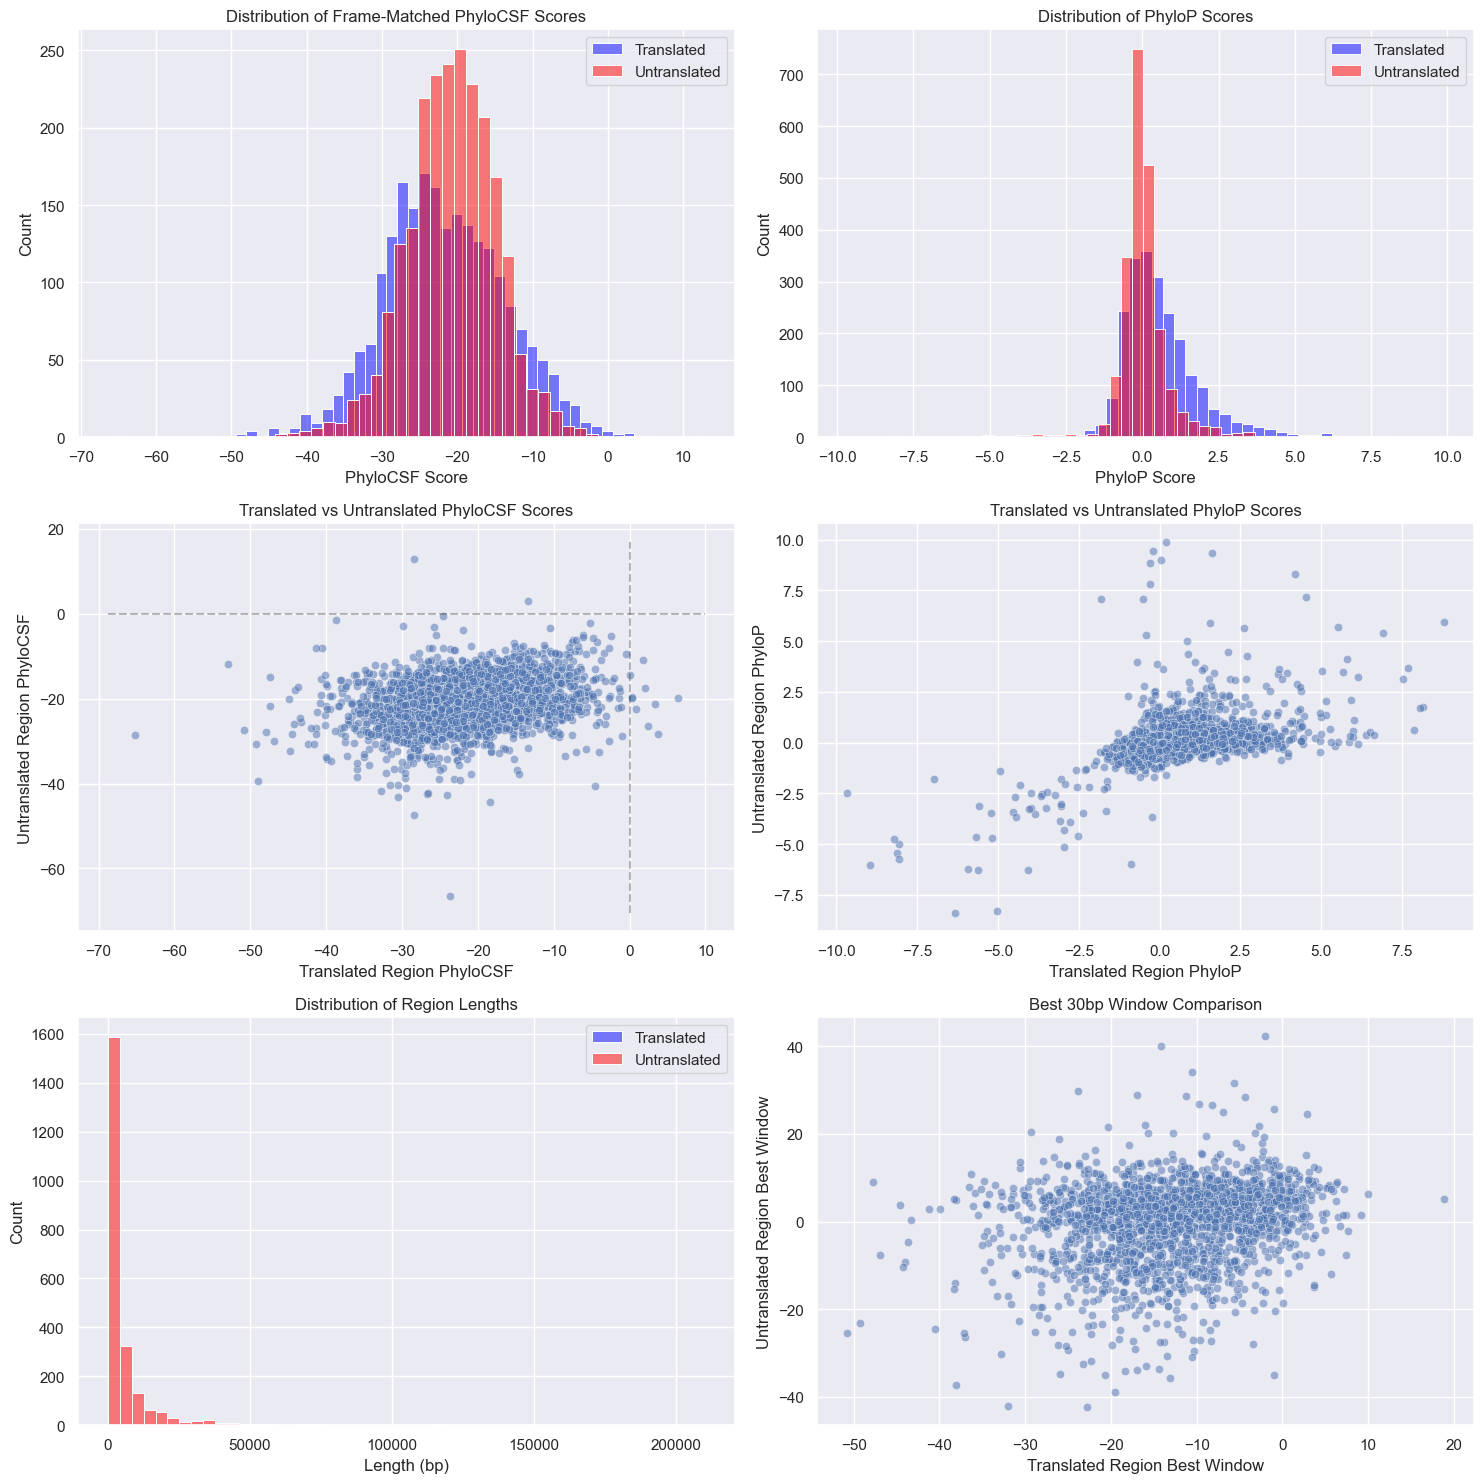


Writing phylocsf BED file...
../results/translated_introns/bed/intron_phylocsf_20250110.bed
Wrote 4581 entries to ../results/translated_introns/bed/intron_phylocsf_20250110.bed

First few lines of BED file:
shape: (5, 6)
┌──────────┬──────────┬──────────┬──────────────────────────────┬───────────┬────────┐
│ chr_name ┆ start    ┆ end      ┆ feature_name                 ┆ bed_score ┆ strand │
│ ---      ┆ ---      ┆ ---      ┆ ---                          ┆ ---       ┆ ---    │
│ str      ┆ i64      ┆ i64      ┆ str                          ┆ i64       ┆ str    │
╞══════════╪══════════╪══════════╪══════════════════════════════╪═══════════╪════════╡
│ chr1     ┆ 1013576  ┆ 1013732  ┆ ENST00000649529_1_translated ┆ 583       ┆ +      │
│ chr1     ┆ 22563731 ┆ 22563824 ┆ ENST00000166244_1_translated ┆ 805       ┆ +      │
│ chr1     ┆ 22711045 ┆ 22711291 ┆ ENST00000374630_1_translated ┆ 889       ┆ +      │
│ chr1     ┆ 28553137 ┆ 28553209 ┆ ENST00000373830_1_translated ┆ 655       ┆ +   

In [20]:
# Show distribution of scores for both regions
print("\nScore statistics for intron regions:")
print(scored_df.select([
   "transcript_id",
   "translated_coords",
   "intron_coords", 
   "strand",
   "translated_frame_score",
   "untranslated_frame_score",
   "translated_phylop",
   "untranslated_phylop",
   "frame"
]).head(10))

# Create visualization comparing translated and untranslated regions
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

# PhyloCSF scores distribution - translated vs untranslated
data = scored_df.to_pandas()

# Plot 1: PhyloCSF scores
sns.histplot(
    data=data['translated_frame_score'].dropna(),
    bins=50,
    ax=axes[0],
    color='blue',
    alpha=0.5,
    label='Translated'
)
sns.histplot(
    data=data['untranslated_frame_score'].dropna(),
    bins=50,
    ax=axes[0],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# Plot 2: PhyloP scores
sns.histplot(
    data=data['translated_phylop'].dropna(),
    bins=50,
    ax=axes[1],
    color='blue',
    alpha=0.5,
    label='Translated'
)
sns.histplot(
    data=data['untranslated_phylop'].dropna(),
    bins=50,
    ax=axes[1],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# Plot 3: PhyloCSF comparison
sns.scatterplot(
    data=data.dropna(subset=['translated_frame_score', 'untranslated_frame_score']),
    x='translated_frame_score',
    y='untranslated_frame_score',
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title("Translated vs Untranslated PhyloCSF Scores")
axes[2].set_xlabel("Translated Region PhyloCSF")
axes[2].set_ylabel("Untranslated Region PhyloCSF")
axes[2].plot([0, 0], axes[2].get_ylim(), 'k--', alpha=0.3)  # vertical line at x=0
axes[2].plot(axes[2].get_xlim(), [0, 0], 'k--', alpha=0.3)  # horizontal line at y=0

# Plot 4: PhyloP comparison
sns.scatterplot(
    data=data.dropna(subset=['translated_phylop', 'untranslated_phylop']),
    x='translated_phylop',
    y='untranslated_phylop',
    alpha=0.5,
    ax=axes[3]
)
axes[3].set_title("Translated vs Untranslated PhyloP Scores")
axes[3].set_xlabel("Translated Region PhyloP")
axes[3].set_ylabel("Untranslated Region PhyloP")

# Plot 5: Region lengths
sns.histplot(
    data=data['translated_length'].dropna(),
    bins=50,
    ax=axes[4],
    color='blue',
    alpha=0.5,
    label='Translated'
)
sns.histplot(
    data=data['untranslated_length'].dropna(),
    bins=50,
    ax=axes[4],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[4].set_title("Distribution of Region Lengths")
axes[4].set_xlabel("Length (bp)")
axes[4].legend()

# Plot 6: Window max scores
sns.scatterplot(
    data=data.dropna(subset=['translated_window_max', 'untranslated_window_max']),
    x='translated_window_max',
    y='untranslated_window_max',
    alpha=0.5,
    ax=axes[5]
)
axes[5].set_title("Best 30bp Window Comparison")
axes[5].set_xlabel("Translated Region Best Window")
axes[5].set_ylabel("Untranslated Region Best Window")

plt.tight_layout()
plt.show()

# Modified BED file writer for our specific columns
# Modified BED file writer for our specific columns
def write_scored_bed(df, translated_col, untranslated_col, output_path, scale_factor=1000):
    """Write BED file with both translated and untranslated regions"""
    
    # Create entries for translated regions
    translated_df = (df
        .with_columns([
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            pl.col("thickStart").alias("start"),
            pl.col("thickEnd").alias("end"),
            # Ensure unique names for browser display
            pl.format("{}_translated", pl.col("name")).alias("feature_name"),
            # Scale scores to BED format (0-1000)
            pl.when(pl.col(translated_col).is_null() | pl.col(translated_col).is_nan())
            .then(0)
            .otherwise(
                ((pl.col(translated_col) - pl.col(translated_col).filter(~pl.col(translated_col).is_nan()).min()) / 
                 (pl.col(translated_col).filter(~pl.col(translated_col).is_nan()).max() - 
                  pl.col(translated_col).filter(~pl.col(translated_col).is_nan()).min()) * scale_factor)
            )
            .floor()
            .cast(pl.Int64)
            .clip(0, 1000)
            .alias("bed_score")
        ])
        .select([
            "chr_name",
            "start",
            "end",
            "feature_name",
            "bed_score",
            "strand"
        ]))
    
    # Create entries for untranslated regions
    untranslated_df = (df
        .filter(pl.col("untranslated_length") > 0)  # Only include regions with untranslated sequence
        .with_columns([
            pl.format("chr{}", pl.col("chrom")).alias("chr_name"),
            pl.format("{}_untranslated", pl.col("name")).alias("feature_name"),
            # Scale scores for untranslated regions
            pl.when(pl.col(untranslated_col).is_null() | pl.col(untranslated_col).is_nan())
            .then(0)
            .otherwise(
                ((pl.col(untranslated_col) - pl.col(untranslated_col).filter(~pl.col(untranslated_col).is_nan()).min()) / 
                 (pl.col(untranslated_col).filter(~pl.col(untranslated_col).is_nan()).max() - 
                  pl.col(untranslated_col).filter(~pl.col(untranslated_col).is_nan()).min()) * scale_factor)
            )
            .floor()
            .cast(pl.Int64)
            .clip(0, 1000)
            .alias("bed_score")
        ]))
    
    # Get coordinates for untranslated regions
    untranslated_df = untranslated_df.with_columns([
        pl.col("intron_start").alias("start"),
        pl.col("intron_end").alias("end")
    ]).select([
        "chr_name",
        "start",
        "end",
        "feature_name",
        "bed_score",
        "strand"
    ])
    
    # Combine and write
    combined_df = pl.concat([translated_df, untranslated_df])
    
    combined_df.write_csv(
        output_path,
        separator="\t",
        include_header=False
    )
    
    print(f"Wrote {len(combined_df)} entries to {output_path}")
    print("\nFirst few lines of BED file:")
    print(combined_df.head())
    
    return combined_df
          

# Generate BED files for different score types
date_str = datetime.now().strftime("%Y%m%d")
for score_type, (translated_col, untranslated_col) in {
    "phylocsf": ("translated_frame_score", "untranslated_frame_score"),
    "phylop": ("translated_phylop", "untranslated_phylop"),
    "window": ("translated_window_max", "untranslated_window_max")
}.items():
    output_path = RESULTS_DIR / "bed" / f"intron_{score_type}_{date_str}.bed"
    print(f"\nWriting {score_type} BED file...")
    print(output_path)
    write_scored_bed(scored_df, translated_col, untranslated_col, output_path)

# Print score statistics
print("\nScore column statistics:")
for col_pair in [
    ("translated_frame_score", "untranslated_frame_score"),
    ("translated_phylop", "untranslated_phylop"),
    ("translated_window_max", "untranslated_window_max")
]:
    for col in col_pair:
        if col in scored_df.columns:
            print(f"\n{col}:")
            print(f"Total values: {len(scored_df)}")
            print(f"Null values: {scored_df.filter(pl.col(col).is_null()).height}")
            print(f"NaN values: {scored_df.filter(pl.col(col).is_nan()).height}")
            print(f"Negative values: {scored_df.filter(pl.col(col) < 0).height}")
            print("Overall statistics:")
            print(scored_df.select(pl.col(col)).describe())

## Finding Novel Extension Regions

After calculating conservation scores for all potential N-terminal extensions, we need to identify which ones are truly novel (i.e., don't overlap with known coding sequences in other transcripts). This requires:

1. Prerequisites:
  - Bedtools installed (`conda install -c bioconda bedtools`)
  - Our scored BED files from the conservation analysis
  - GENCODE v47 CDS annotations in BED format

2. Steps to identify novel extensions:

```bash
# First convert GENCODE GTF CDS regions to BED
# If using UCSC genome browser coordinates (our case):
awk '$3=="CDS" {print $1"\t"$4-1"\t"$5}' data/raw/gencode.v47.annotation.gtf > gencode.v47.cds.bed


# Use bedtools ictersect to find non-overlapping regions - Examples
# For matched frame scores:
bedtools intersect -v -a cte_matched_frame_20241031.bed -b gencode.v47.cds.bed > novel_cte_matched_frame_20241031.bed

# For PhyloP scores:
bedtools intersect -v -a cte_phylop_20241031.bed -b gencode.v47.cds.bed > novel_cte_phylop_20241031.bed

# For window max scores:
bedtools intersect -v -a cte_window_max_20241031.bed -b gencode.v47.cds.bed > novel_cte_window_max_20241031.bed

In [21]:
def generate_novel_beds(scored_df, gencode_path, output_dir, date_str):
    """
    Generate both full and novel (non-CDS-overlapping) BED files
    """
    # First get CDS regions from GENCODE
    print("Loading GENCODE CDS regions...")
    cds_gr = pr.read_gtf(gencode_path)
    cds_gr = cds_gr[cds_gr.Feature == "CDS"]
    
    # Convert CDS to BED format (chr, start, end)
    cds_bed = pd.DataFrame({
        'Chromosome': cds_gr.Chromosome,
        'Start': cds_gr.Start,
        'End': cds_gr.End
    })
    cds_gr = pr.PyRanges(cds_bed)
    
    # Generate BED files for different score types
    score_pairs = {
        "phylocsf": ("translated_frame_score", "untranslated_frame_score"),
        "phylop": ("translated_phylop", "untranslated_phylop")
    }
    
    results = {}
    for score_type, (translated_col, untranslated_col) in score_pairs.items():
        # Generate full BED file
        full_path = output_dir / f"intron_{score_type}_{date_str}.bed"
        print(f"\nGenerating {score_type} BED files...")
        full_bed_df = write_scored_bed(scored_df, translated_col, untranslated_col, full_path)
        
        # Convert to PyRanges
        full_gr = pr.PyRanges(
            pd.DataFrame({
                'Chromosome': full_bed_df['chr_name'],
                'Start': full_bed_df['start'],
                'End': full_bed_df['end'],
                'Name': full_bed_df['feature_name'],
                'Score': full_bed_df['bed_score'],
                'Strand': full_bed_df['strand']
            })
        )
        
        # Find non-overlapping regions
        novel_gr = full_gr.subtract(cds_gr)
        
        # Save novel regions
        novel_path = output_dir / f"novel_intron_{score_type}_{date_str}.bed"
        novel_gr.to_bed(novel_path)
        
        print(f"Wrote {len(full_gr)} regions to {full_path}")
        print(f"Wrote {len(novel_gr)} novel regions to {novel_path}")
        
        results[score_type] = {
            'full': full_gr,
            'novel': novel_gr
        }
    
    return results

novel_results = generate_novel_beds(
    scored_df=scored_df,
    gencode_path=gencode_path,
    output_dir=RESULTS_DIR / "bed",
    date_str=date_str
)

# Print summary statistics
for score_type in novel_results:
    full_count = len(novel_results[score_type]['full'])
    novel_count = len(novel_results[score_type]['novel'])
    print(f"\n{score_type} results:")
    print(f"Total regions: {full_count}")
    print(f"Novel regions: {novel_count}")
    print(f"Percentage novel: {(novel_count/full_count)*100:.1f}%")

Loading GENCODE CDS regions...

Generating phylocsf BED files...
Wrote 4581 entries to ../results/translated_introns/bed/intron_phylocsf_20250110.bed

First few lines of BED file:
shape: (5, 6)
┌──────────┬──────────┬──────────┬──────────────────────────────┬───────────┬────────┐
│ chr_name ┆ start    ┆ end      ┆ feature_name                 ┆ bed_score ┆ strand │
│ ---      ┆ ---      ┆ ---      ┆ ---                          ┆ ---       ┆ ---    │
│ str      ┆ i64      ┆ i64      ┆ str                          ┆ i64       ┆ str    │
╞══════════╪══════════╪══════════╪══════════════════════════════╪═══════════╪════════╡
│ chr1     ┆ 1013576  ┆ 1013732  ┆ ENST00000649529_1_translated ┆ 583       ┆ +      │
│ chr1     ┆ 22563731 ┆ 22563824 ┆ ENST00000166244_1_translated ┆ 805       ┆ +      │
│ chr1     ┆ 22711045 ┆ 22711291 ┆ ENST00000374630_1_translated ┆ 889       ┆ +      │
│ chr1     ┆ 28553137 ┆ 28553209 ┆ ENST00000373830_1_translated ┆ 655       ┆ +      │
│ chr1     ┆ 28737147 ┆

## Results Output Organization

We should save both figures and data files for reproducibility and future reference. Here's what we should output:

### Figures
1. **Distribution Plots** (`results/cte/figures/`)
  - Score distributions:
    ```python
    # Distribution plots (4-panel)
    fig.savefig(RESULTS_DIR / "figures" / f"cte_score_distributions_{date_str}.pdf")
    fig.savefig(RESULTS_DIR / "figures" / f"cte_score_distributions_{date_str}.png", dpi=300)
    ```

2. **Correlation Plots**
  - PhyloCSF vs PhyloP
  - Score vs length relationships
  - Separate plots for clarity

### Tables/Data Files 
1. **Summary Statistics** (`results/cte/tables/`)


Wrote 4581 entries to ../results/translated_introns/bed/intron_phylocsf_20250110.bed

First few lines of BED file:
shape: (5, 6)
┌──────────┬──────────┬──────────┬──────────────────────────────┬───────────┬────────┐
│ chr_name ┆ start    ┆ end      ┆ feature_name                 ┆ bed_score ┆ strand │
│ ---      ┆ ---      ┆ ---      ┆ ---                          ┆ ---       ┆ ---    │
│ str      ┆ i64      ┆ i64      ┆ str                          ┆ i64       ┆ str    │
╞══════════╪══════════╪══════════╪══════════════════════════════╪═══════════╪════════╡
│ chr1     ┆ 1013576  ┆ 1013732  ┆ ENST00000649529_1_translated ┆ 583       ┆ +      │
│ chr1     ┆ 22563731 ┆ 22563824 ┆ ENST00000166244_1_translated ┆ 805       ┆ +      │
│ chr1     ┆ 22711045 ┆ 22711291 ┆ ENST00000374630_1_translated ┆ 889       ┆ +      │
│ chr1     ┆ 28553137 ┆ 28553209 ┆ ENST00000373830_1_translated ┆ 655       ┆ +      │
│ chr1     ┆ 28737147 ┆ 28737423 ┆ ENST00000373812_1_translated ┆ 771       ┆ +      │
└

<Figure size 1500x1000 with 0 Axes>

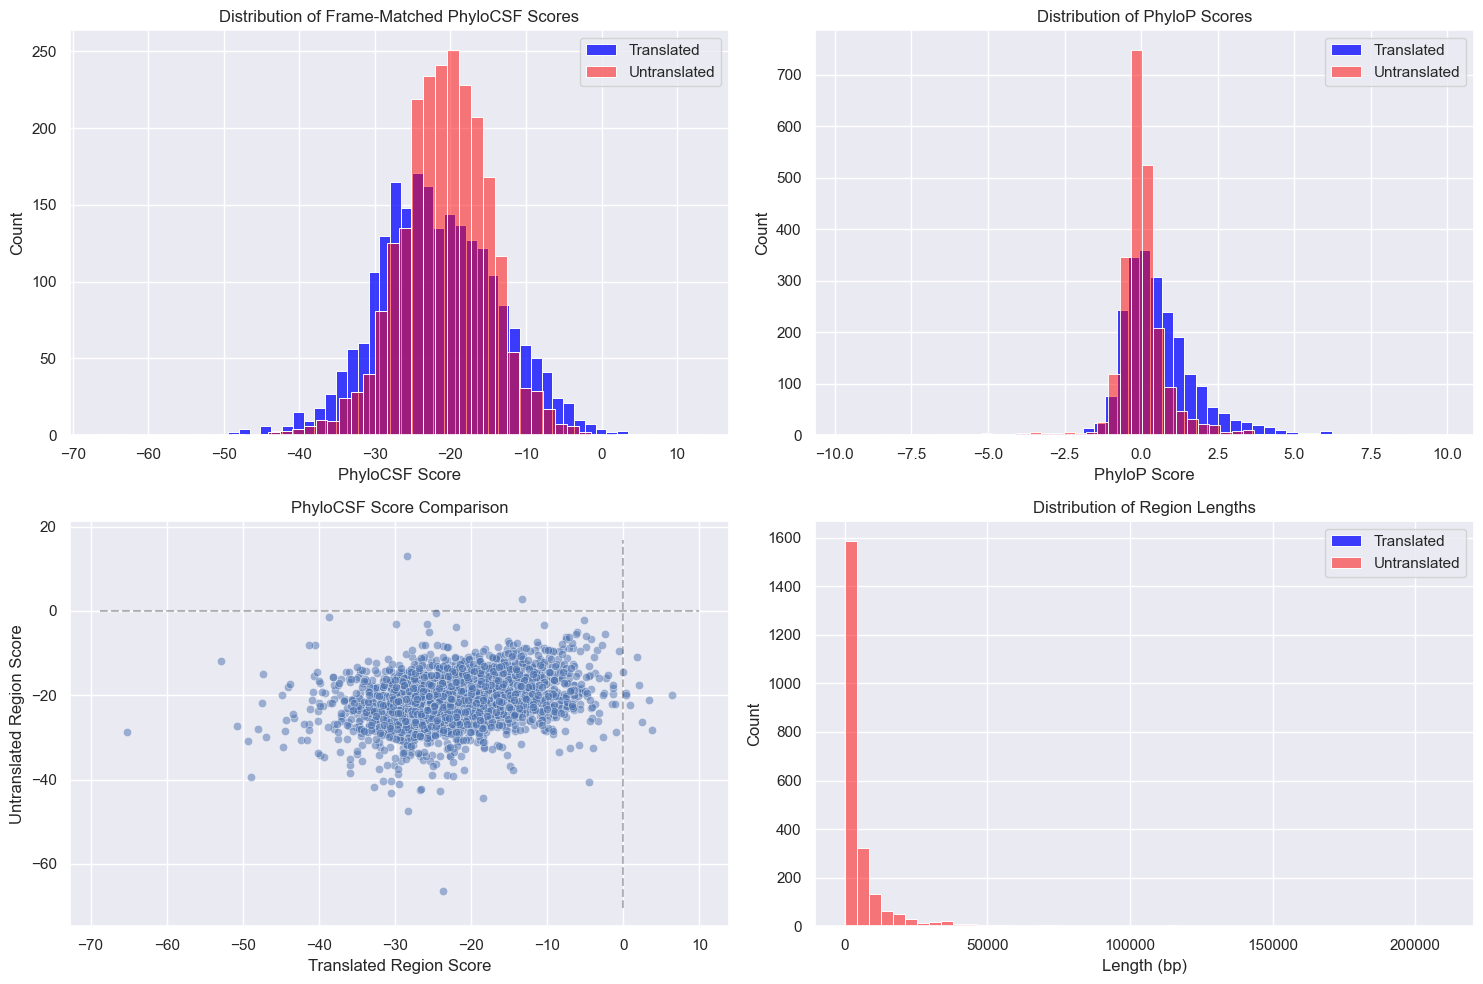

In [22]:
# Create directory structure
# RESULTS_DIR = Path("../results/retained_introns")
for subdir in ["figures", "tables", "bed"]:
    (RESULTS_DIR / subdir).mkdir(parents=True, exist_ok=True)

# Get current date for file naming
date_str = datetime.now().strftime("%Y%m%d")

# Save figures
plt.figure(figsize=(15, 10))
# Distribution plots (4-panel)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

# PhyloCSF scores distribution
sns.histplot(
    data=scored_df.to_pandas(), 
    x="translated_frame_score",
    bins=50,
    ax=axes[0],
    color='blue',
    label='Translated'
)
sns.histplot(
    data=scored_df.to_pandas(), 
    x="untranslated_frame_score",
    bins=50,
    ax=axes[0],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[0].set_title("Distribution of Frame-Matched PhyloCSF Scores")
axes[0].set_xlabel("PhyloCSF Score")
axes[0].legend()

# PhyloP score distribution
sns.histplot(
    data=scored_df.to_pandas(), 
    x="translated_phylop",
    bins=50,
    ax=axes[1],
    color='blue',
    label='Translated'
)
sns.histplot(
    data=scored_df.to_pandas(), 
    x="untranslated_phylop",
    bins=50,
    ax=axes[1],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[1].set_title("Distribution of PhyloP Scores")
axes[1].set_xlabel("PhyloP Score")
axes[1].legend()

# PhyloCSF comparison
sns.scatterplot(
    data=scored_df.to_pandas(),
    x="translated_frame_score",
    y="untranslated_frame_score",
    alpha=0.5,
    ax=axes[2]
)
axes[2].set_title("PhyloCSF Score Comparison")
axes[2].set_xlabel("Translated Region Score")
axes[2].set_ylabel("Untranslated Region Score")
axes[2].plot([0, 0], axes[2].get_ylim(), 'k--', alpha=0.3)
axes[2].plot(axes[2].get_xlim(), [0, 0], 'k--', alpha=0.3)

# Region lengths
sns.histplot(
    data=scored_df.to_pandas(),
    x="translated_length",
    bins=50,
    ax=axes[3],
    color='blue',
    label='Translated'
)
sns.histplot(
    data=scored_df.to_pandas(),
    x="untranslated_length",
    bins=50,
    ax=axes[3],
    color='red',
    alpha=0.5,
    label='Untranslated'
)
axes[3].set_title("Distribution of Region Lengths")
axes[3].set_xlabel("Length (bp)")
axes[3].legend()

plt.tight_layout()

# Save the figure
fig.savefig(RESULTS_DIR / "figures" / f"intron_score_distributions_{date_str}.pdf")
fig.savefig(RESULTS_DIR / "figures" / f"intron_score_distributions_{date_str}.png", dpi=300)

# Save summary statistics
metrics = [
    "translated_frame_score",
    "untranslated_frame_score",
    "translated_phylop",
    "untranslated_phylop",
    "translated_window_max",
    "untranslated_window_max",
    "translated_length",
    "untranslated_length"
]

summary_stats = scored_df.select(metrics).describe()
summary_stats.write_csv(RESULTS_DIR / "tables" / f"intron_summary_stats_{date_str}.tsv", separator="\t")

# Save full results
scored_df.write_csv(RESULTS_DIR / "tables" / f"intron_full_results_{date_str}.tsv", separator="\t")

# Save high-confidence results
high_conf = scored_df.filter(
    (pl.col("translated_frame_score") > 10) &
    (pl.col("translated_phylop") > 2) &
    (pl.col("translated_frame_score") > pl.col("untranslated_frame_score") * 2)
)
high_conf.write_csv(RESULTS_DIR / "tables" / f"intron_high_confidence_{date_str}.tsv", separator="\t")

# Save BED files
for score_type, (translated_col, untranslated_col) in {
    "phylocsf": ("translated_frame_score", "untranslated_frame_score"),
    "phylop": ("translated_phylop", "untranslated_phylop"),
    "window": ("translated_window_max", "untranslated_window_max")
}.items():
    output_path = RESULTS_DIR / "bed" / f"intron_{score_type}_{date_str}.bed"
    write_scored_bed(scored_df, translated_col, untranslated_col, output_path)

print("Results saved in:")
print(f"- Figures: {RESULTS_DIR}/figures/")
print(f"- Tables: {RESULTS_DIR}/tables/")
print(f"- BED files: {RESULTS_DIR}/bed/")

In [23]:
scored_df

chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,transcript_id,region_length,translated_frame_score,translated_max_score,translated_phylop,translated_window_max,untranslated_frame_score,untranslated_max_score,untranslated_phylop,untranslated_window_max,translated_length,untranslated_length,intron_start,intron_end,frame,translated_coords,intron_coords
str,i64,i64,str,i64,str,i64,i64,i64,i64,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,str,str
"""1""",1013576,1013732,"""ENST00000649529_1""",156,"""+""",1013576,1013732,0,1,"""156""","""0""","""ENST00000649529""",156,-23.455135,-23.455135,-0.363019,-6.3096,-28.361789,-27.295877,-0.328809,-13.7229,156,251,1013576,1013983,3,"""1:1013576-1013732""","""1:1013576-1013983"""
"""1""",22563731,22563824,"""ENST00000166244_1""",93,"""+""",22563731,22563824,0,1,"""93""","""0""","""ENST00000166244""",93,-7.554032,-5.568086,1.928796,2.7125,-25.098858,-24.472444,0.162624,1.9283,93,5466,22563729,22569288,3,"""1:22563731-22563824""","""1:22563729-22569288"""
"""1""",22711045,22711291,"""ENST00000374630_1""",246,"""+""",22711045,22711291,0,1,"""246""","""0""","""ENST00000374630""",246,-1.519325,-0.86045,4.368772,5.3291,-22.111762,-21.871133,0.120767,7.795,246,70131,22711043,22781420,2,"""1:22711045-22711291""","""1:22711043-22781420"""
"""1""",28553137,28553209,"""ENST00000373830_1""",72,"""+""",28553137,28553209,0,1,"""72""","""0""","""ENST00000373830""",72,-18.281375,-11.907653,0.975681,-4.0984,-26.802535,-23.635191,-0.2685,-9.3066,72,430,28553137,28553639,2,"""1:28553137-28553209""","""1:28553137-28553639"""
"""1""",28737147,28737423,"""ENST00000373812_1""",276,"""+""",28737147,28737423,0,1,"""276""","""0""","""ENST00000373812""",276,-9.948363,-8.350425,2.530649,6.763,-15.604744,-10.671906,1.060654,-1.1172,276,234,28737147,28737657,1,"""1:28737147-28737423""","""1:28737147-28737657"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""9""",39175804,39175948,"""ENST00000297668_1""",144,"""-""",39175804,39175948,0,1,"""144""","""0""","""ENST00000297668""",144,-16.373796,-13.900972,-1.656431,-10.941893,-13.305047,-13.305047,-0.252332,0.051,144,4174,39171630,39175948,2,"""9:39175804-39175948""","""9:39171630-39175948"""
"""9""",124356565,124356763,"""ENST00000259457_1""",198,"""-""",124356565,124356763,0,1,"""198""","""0""","""ENST00000259457""",198,-26.593141,-26.593141,0.186884,-12.9714,-24.535616,-23.490516,-0.345711,-5.988375,198,2856,124353709,124356763,2,"""9:124356565-124356763""","""9:124353709-124356763"""
"""9""",136219007,136219028,"""ENST00000358701_1""",21,"""-""",136219007,136219028,0,1,"""21""","""0""","""ENST00000358701""",21,-39.901714,-17.647048,0.193524,null,-22.568168,-22.568168,-1.58159,-2.997333,21,200,136218808,136219029,3,"""9:136219007-136219028""","""9:136218808-136219029"""
